# Libraries that we used


In [1]:
import os
import cv2
import glob
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
###########################################
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
#############################################

# Read Dataset

>>Training

In [2]:
train_dir='/kaggle/input/my-dataset/Training/Training'
filepath=[]
labels=[]
folds=os.listdir(train_dir)
for fold in folds:
    filpath=os.path.join(train_dir,fold)
    filelist=os.listdir(filpath)
    for f in filelist:
        fpath=os.path.join(filpath,f)
        filepath.append(fpath)
        labels.append(fold)
f_series=pd.Series(filepath,name='filepath') 
l_series=pd.Series(labels,name='labels')
train_df1=pd.concat([f_series,l_series],axis=1)

In [3]:
train_df1

filepath     labels
0     /kaggle/input/my-dataset/Training/Training/pit...  pituitary
1     /kaggle/input/my-dataset/Training/Training/pit...  pituitary
2     /kaggle/input/my-dataset/Training/Training/pit...  pituitary
3     /kaggle/input/my-dataset/Training/Training/pit...  pituitary
4     /kaggle/input/my-dataset/Training/Training/pit...  pituitary
...                                                 ...        ...
5707  /kaggle/input/my-dataset/Training/Training/gli...     glioma
5708  /kaggle/input/my-dataset/Training/Training/gli...     glioma
5709  /kaggle/input/my-dataset/Training/Training/gli...     glioma
5710  /kaggle/input/my-dataset/Training/Training/gli...     glioma
5711  /kaggle/input/my-dataset/Training/Training/gli...     glioma

[5712 rows x 2 columns]

>>Testing

In [4]:
test_dir='/kaggle/input/my-dataset/Testing/Testing'
filepath=[]
labels=[]
folds=os.listdir(test_dir)
for fold in folds:
    filpath=os.path.join(test_dir,fold)
    filelist=os.listdir(filpath)
    for f in filelist:
        fpath=os.path.join(filpath,f)
        filepath.append(fpath)
        labels.append(fold)
f_series=pd.Series(filepath,name='filepath') 
l_series=pd.Series(labels,name='labels')
test_df1=pd.concat([f_series,l_series],axis=1)

In [5]:
test_df1

filepath     labels
0     /kaggle/input/my-dataset/Testing/Testing/pitui...  pituitary
1     /kaggle/input/my-dataset/Testing/Testing/pitui...  pituitary
2     /kaggle/input/my-dataset/Testing/Testing/pitui...  pituitary
3     /kaggle/input/my-dataset/Testing/Testing/pitui...  pituitary
4     /kaggle/input/my-dataset/Testing/Testing/pitui...  pituitary
...                                                 ...        ...
1306  /kaggle/input/my-dataset/Testing/Testing/gliom...     glioma
1307  /kaggle/input/my-dataset/Testing/Testing/gliom...     glioma
1308  /kaggle/input/my-dataset/Testing/Testing/gliom...     glioma
1309  /kaggle/input/my-dataset/Testing/Testing/gliom...     glioma
1310  /kaggle/input/my-dataset/Testing/Testing/gliom...     glioma

[1311 rows x 2 columns]

# EDA

>>Training

In [6]:
count_train=train_df1["labels"].value_counts()
count_train

labels
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64

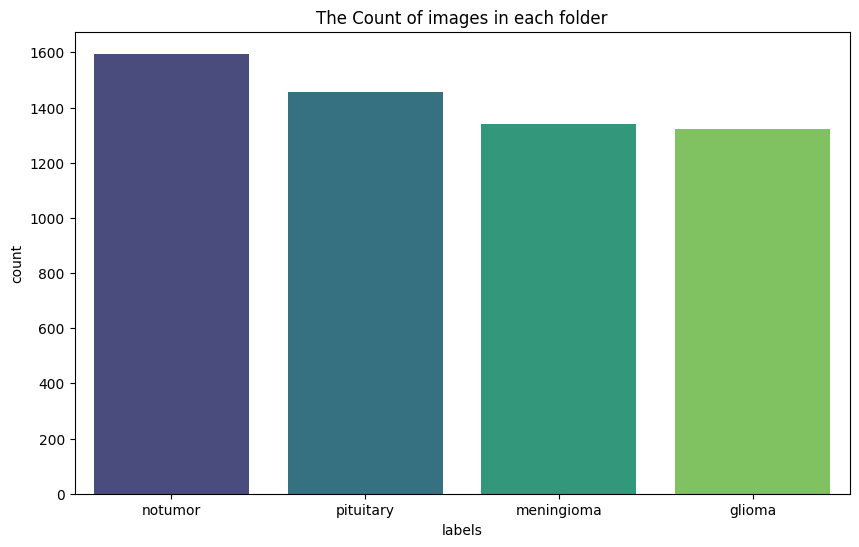

In [7]:
plt.figure(figsize=(10,6))
sns.barplot(x=count_train.index,y=count_train.values,palette='viridis')
plt.title('The Count of images in each folder')
plt.xlabel('labels')
plt.ylabel('count')
plt.show()

>>Testing

In [8]:
count_test=test_df1["labels"].value_counts()
count_test

labels
notumor       405
meningioma    306
pituitary     300
glioma        300
Name: count, dtype: int64

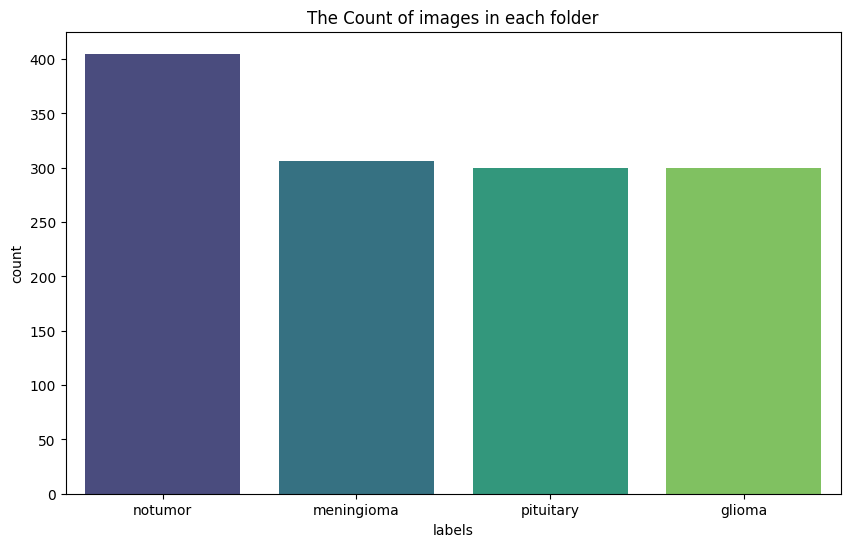

In [9]:
plt.figure(figsize=(10,6))
sns.barplot(x=count_test.index,y=count_test.values,palette='viridis')
plt.title('The Count of images in each folder')
plt.xlabel('labels')
plt.ylabel('count')
plt.show()

# Training Data Spliting into train and validation

In [10]:
train_df,valid_df=train_test_split(train_df1,
                                   test_size=0.2,
                                   random_state=42,
                                   stratify=train_df1['labels'])

In [11]:
print('The shape of training data after spliting   = ',train_df.shape)
print('The shape of validation data after spliting = ',valid_df.shape)

The shape of training data after spliting   =  (4569, 2)
The shape of validation data after spliting =  (1143, 2)


# Create Image Data Generator

In [12]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(    
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df1, x_col= 'filepath', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


# EDA 

>>for training

In [13]:
dict_class = train_gen.class_indices
print('Dictionary: {}'.format(dict_class))

print('-'*75)

class_names = list(dict_class.keys())    # storing class names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
---------------------------------------------------------------------------
Class labels: ['glioma', 'meningioma', 'notumor', 'pituitary']


([<matplotlib.patches.Wedge at 0x7932b98351b0>,
 [Text(0.8220487548618086, 0.7309143893987519, 'glioma'),
  Text(-0.6383985625071291, 0.8957942148668026, 'meningioma'),
  Text(-0.8675409092296418, -0.6762934058624309, 'notumor'),
  Text(0.7655555622153293, -0.7898890309158441, 'pituitary')],
 [Text(0.44839022992462285, 0.3986805760356828, '23%'),
  Text(-0.34821739773116134, 0.48861502629098313, '23%'),
  Text(-0.47320413230707725, -0.3688873122885986, '28%'),
  Text(0.41757576120836143, -0.43084856231773305, '25%')])

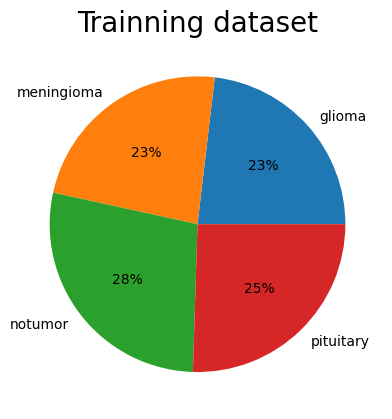

In [14]:
frequency = np.unique(train_gen.classes, return_counts=True)
plt.title("Trainning dataset", fontsize='20')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%')

>>for validation

In [15]:
dict_class = valid_gen.class_indices
print('Dictionary: {}'.format(dict_class))

print('-'*75)

class_names = list(dict_class.keys())    # storing class names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
---------------------------------------------------------------------------
Class labels: ['glioma', 'meningioma', 'notumor', 'pituitary']


([<matplotlib.patches.Wedge at 0x7932bbb86140>,
 [Text(0.8228989928229333, 0.7299570176462461, 'glioma'),
  Text(-0.6364944000968944, 0.8971481921317651, 'meningioma'),
  Text(-0.8692261043025933, -0.6741260858318252, 'notumor'),
  Text(0.7643416542153508, -0.7910637367692576, 'pituitary')],
 [Text(0.4488539960852363, 0.3981583732615887, '23%'),
  Text(-0.34717876368921513, 0.4893535593445991, '23%'),
  Text(-0.4741233296195963, -0.3677051377264501, '28%'),
  Text(0.4169136295720095, -0.43148931096504956, '26%')])

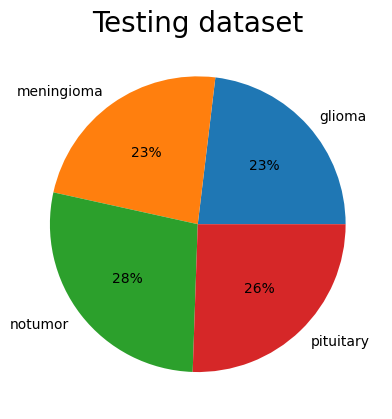

In [16]:
frequency = np.unique(valid_gen.classes, return_counts=True)
plt.title("Validation dataset", fontsize='20')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%')

>>for testing

In [17]:
dict_class = test_gen.class_indices
print('Dictionary: {}'.format(dict_class))

print('-'*75)

class_names = list(dict_class.keys())    # storing class names in a list
print('Class labels: {}'.format(class_names))

Dictionary: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
---------------------------------------------------------------------------
Class labels: ['glioma', 'meningioma', 'notumor', 'pituitary']


([<matplotlib.patches.Wedge at 0x7932b987a0b0>,
 [Text(0.8277837297324334, 0.724412932511742, 'glioma'),
  Text(-0.6213621697100814, 0.9076943615849887, 'meningioma'),
  Text(-0.8172828984570815, -0.7362395424653528, 'notumor'),
  Text(0.8277837297324335, -0.7244129325117419, 'pituitary')],
 [Text(0.45151839803587274, 0.39513432682458655, '23%'),
  Text(-0.3389248198418625, 0.49510601540999377, '23%'),
  Text(-0.4457906718856807, -0.4015852049811015, '31%'),
  Text(0.4515183980358728, -0.39513432682458643, '23%')])

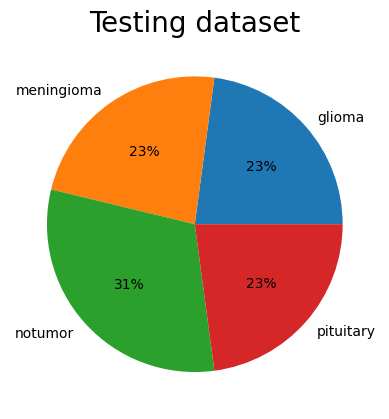

In [18]:
frequency = np.unique(test_gen.classes, return_counts=True)
plt.title("Testing dataset", fontsize='20')
plt.pie(frequency[1], labels = class_names, autopct='%1.0f%%')

# Sample form training data

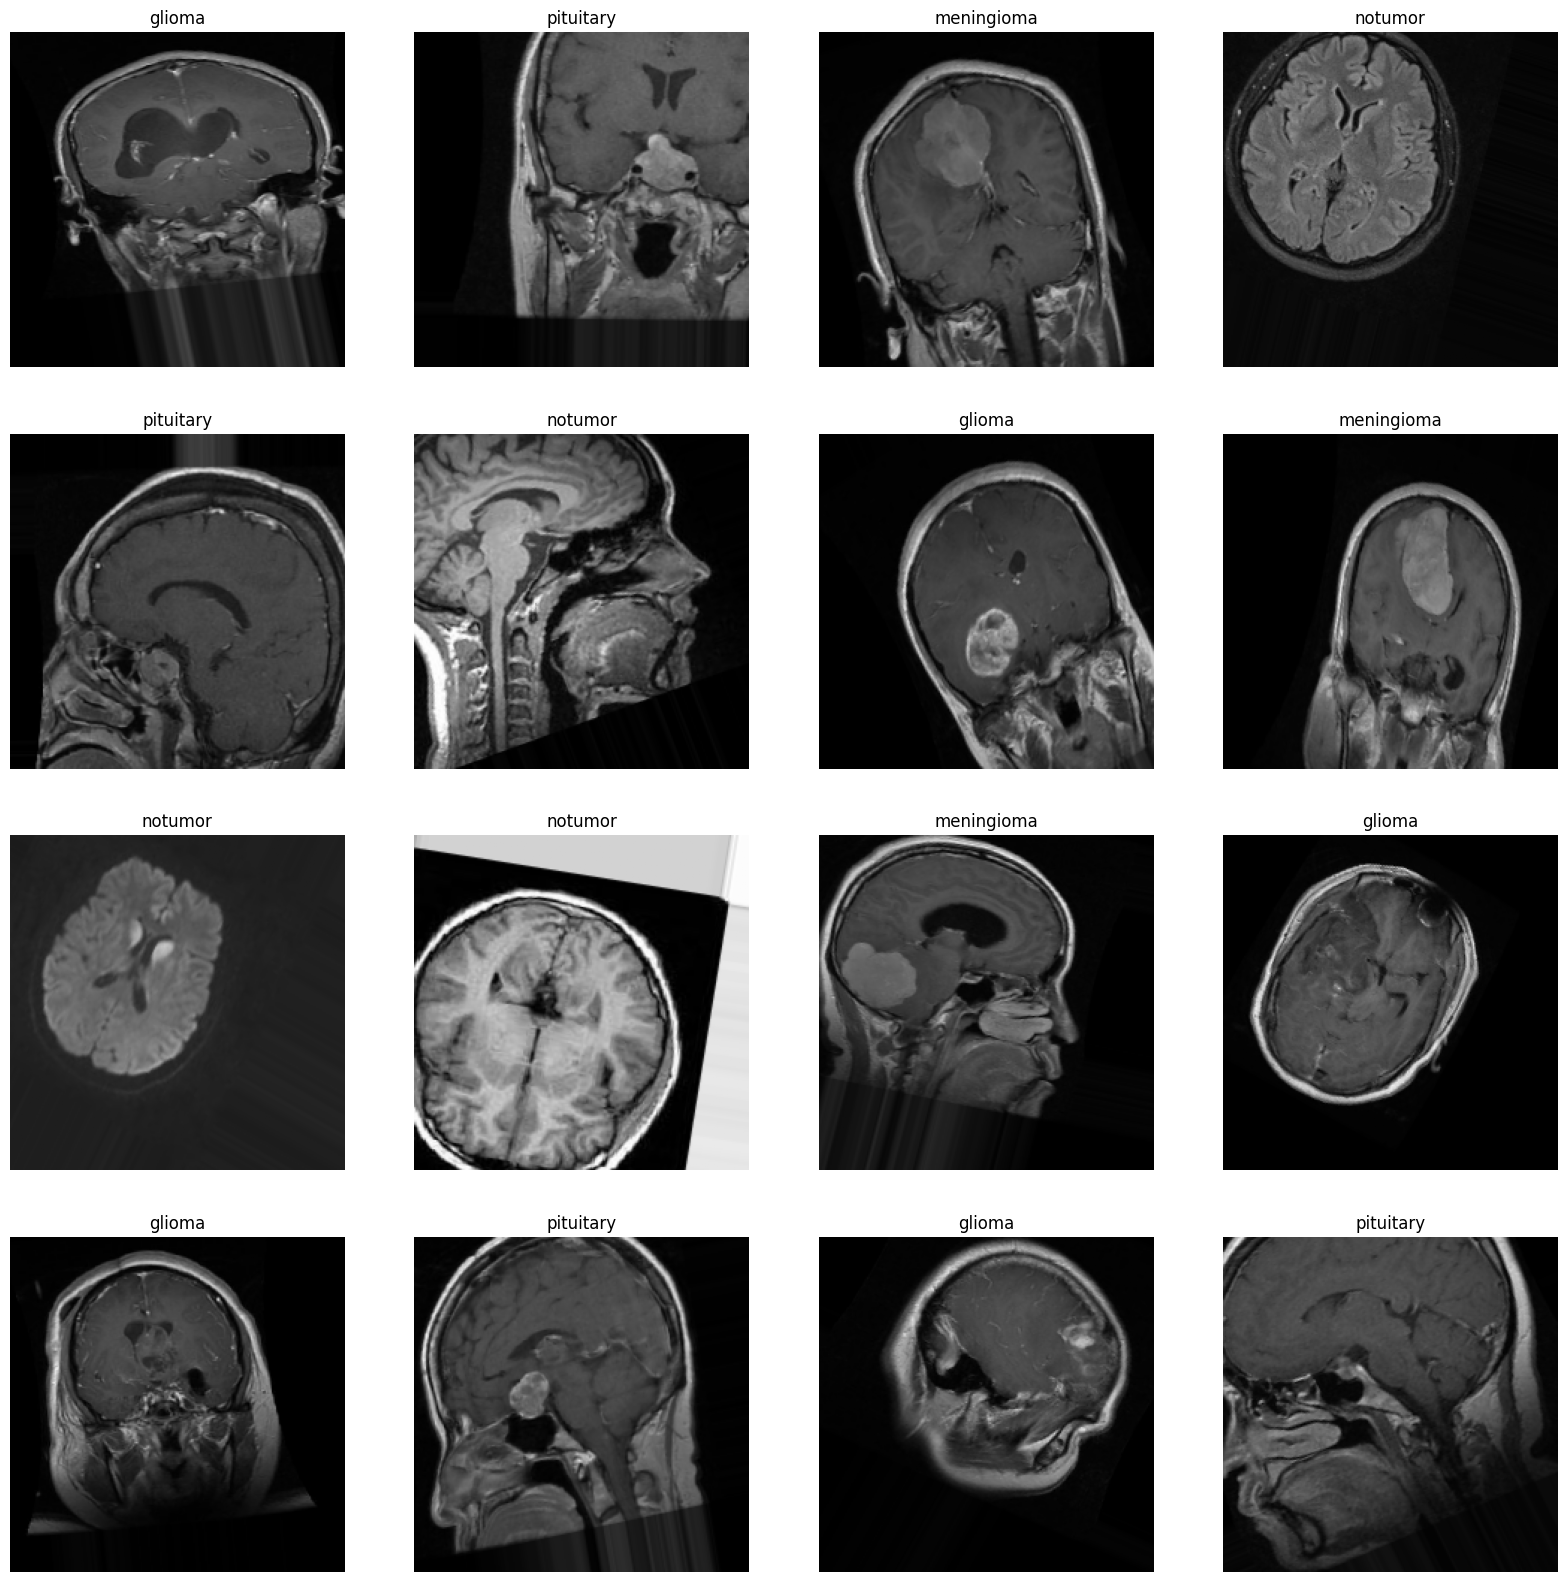

In [19]:
g_dict = train_gen.class_indices    
classes = list(g_dict.keys())      
images, labels = next(train_gen)     

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255      
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'black', fontsize= 12)
    plt.axis('off')
plt.show()

# Sample form validation data

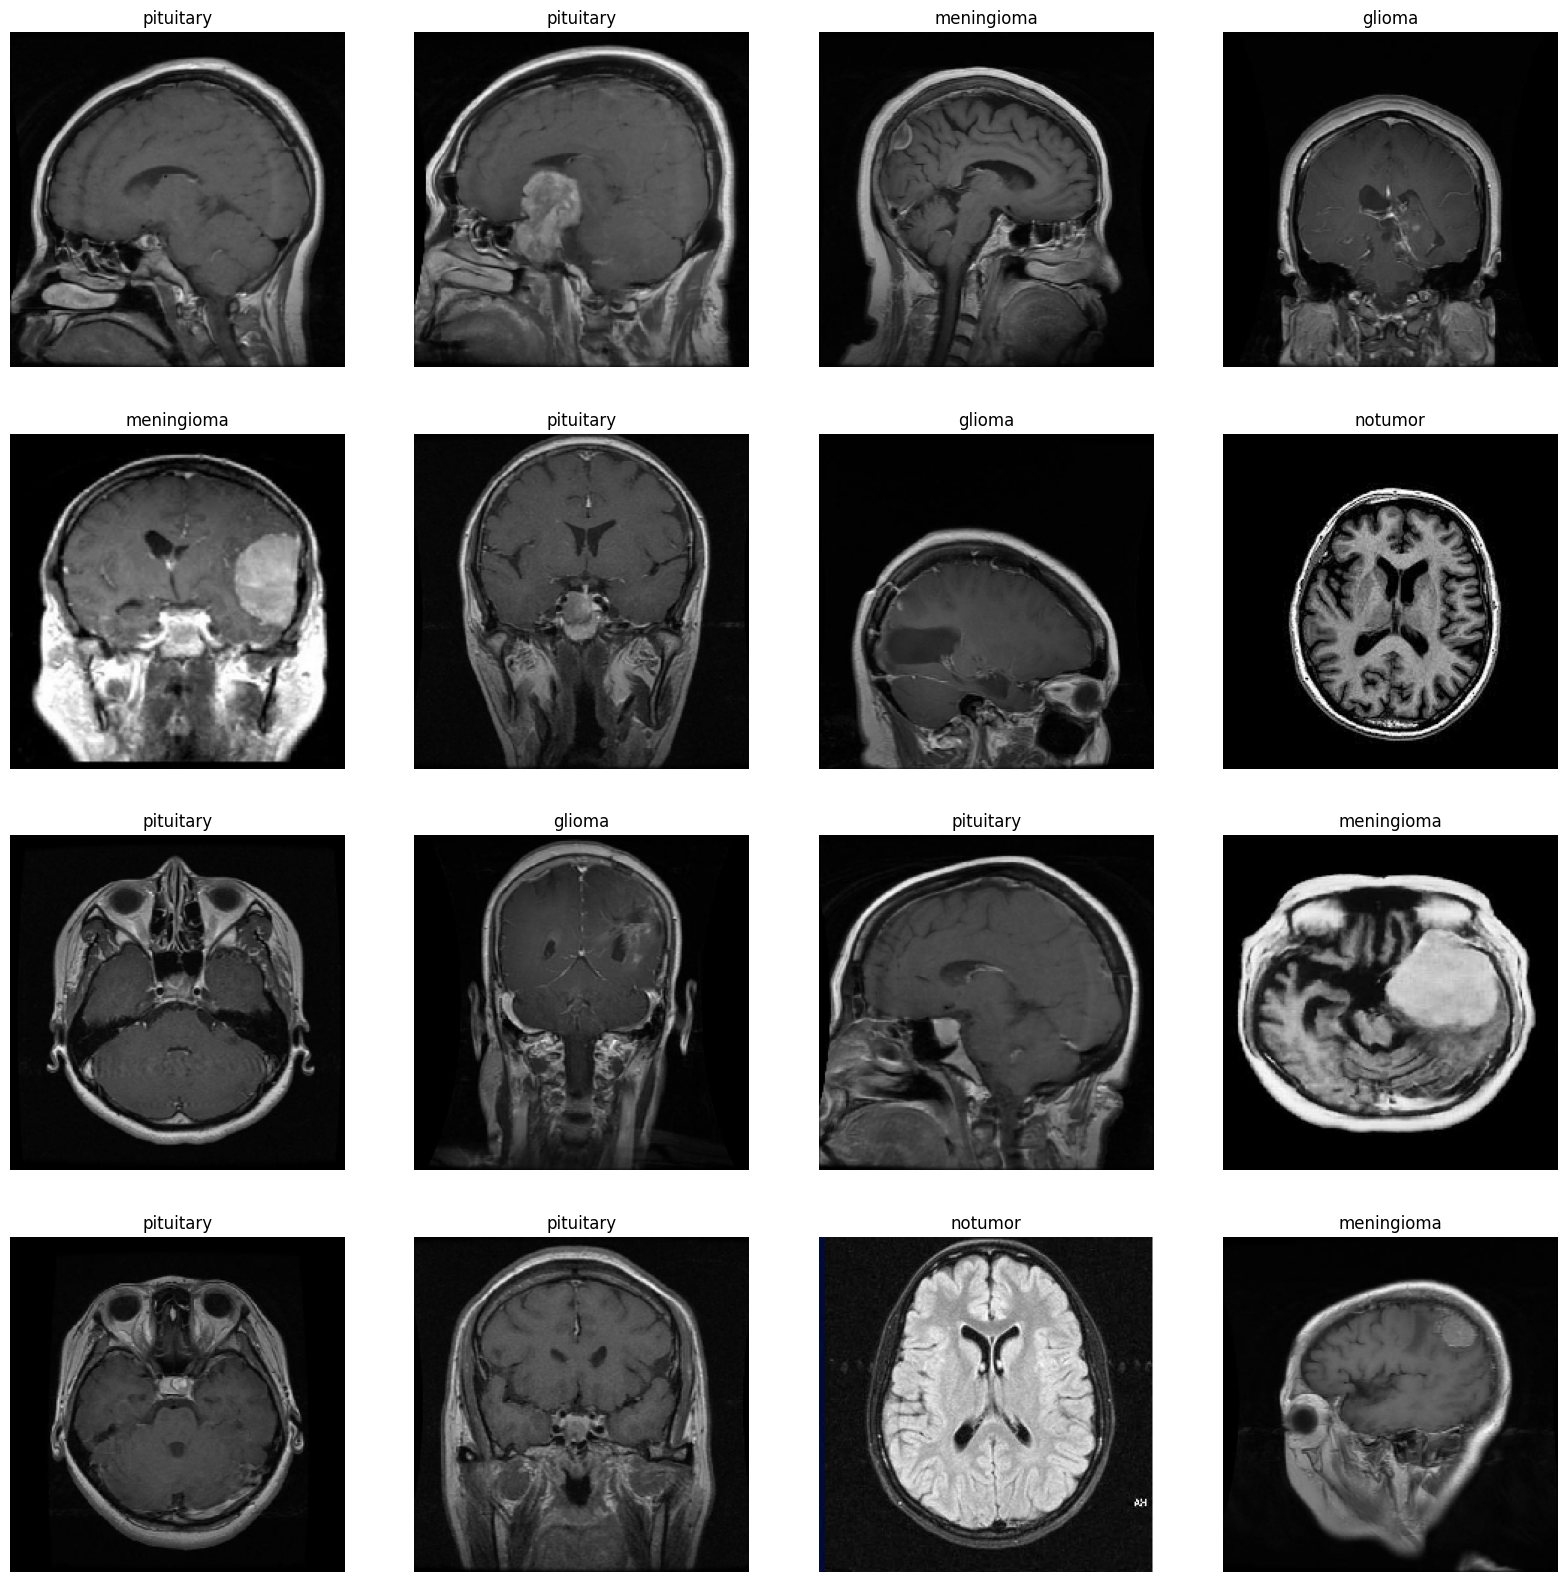

In [20]:
g_dict = valid_gen.class_indices    
classes = list(g_dict.keys())      
images, labels = next(valid_gen)     

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255      
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'black', fontsize= 12)
    plt.axis('off')
plt.show()

# Sample from testing data

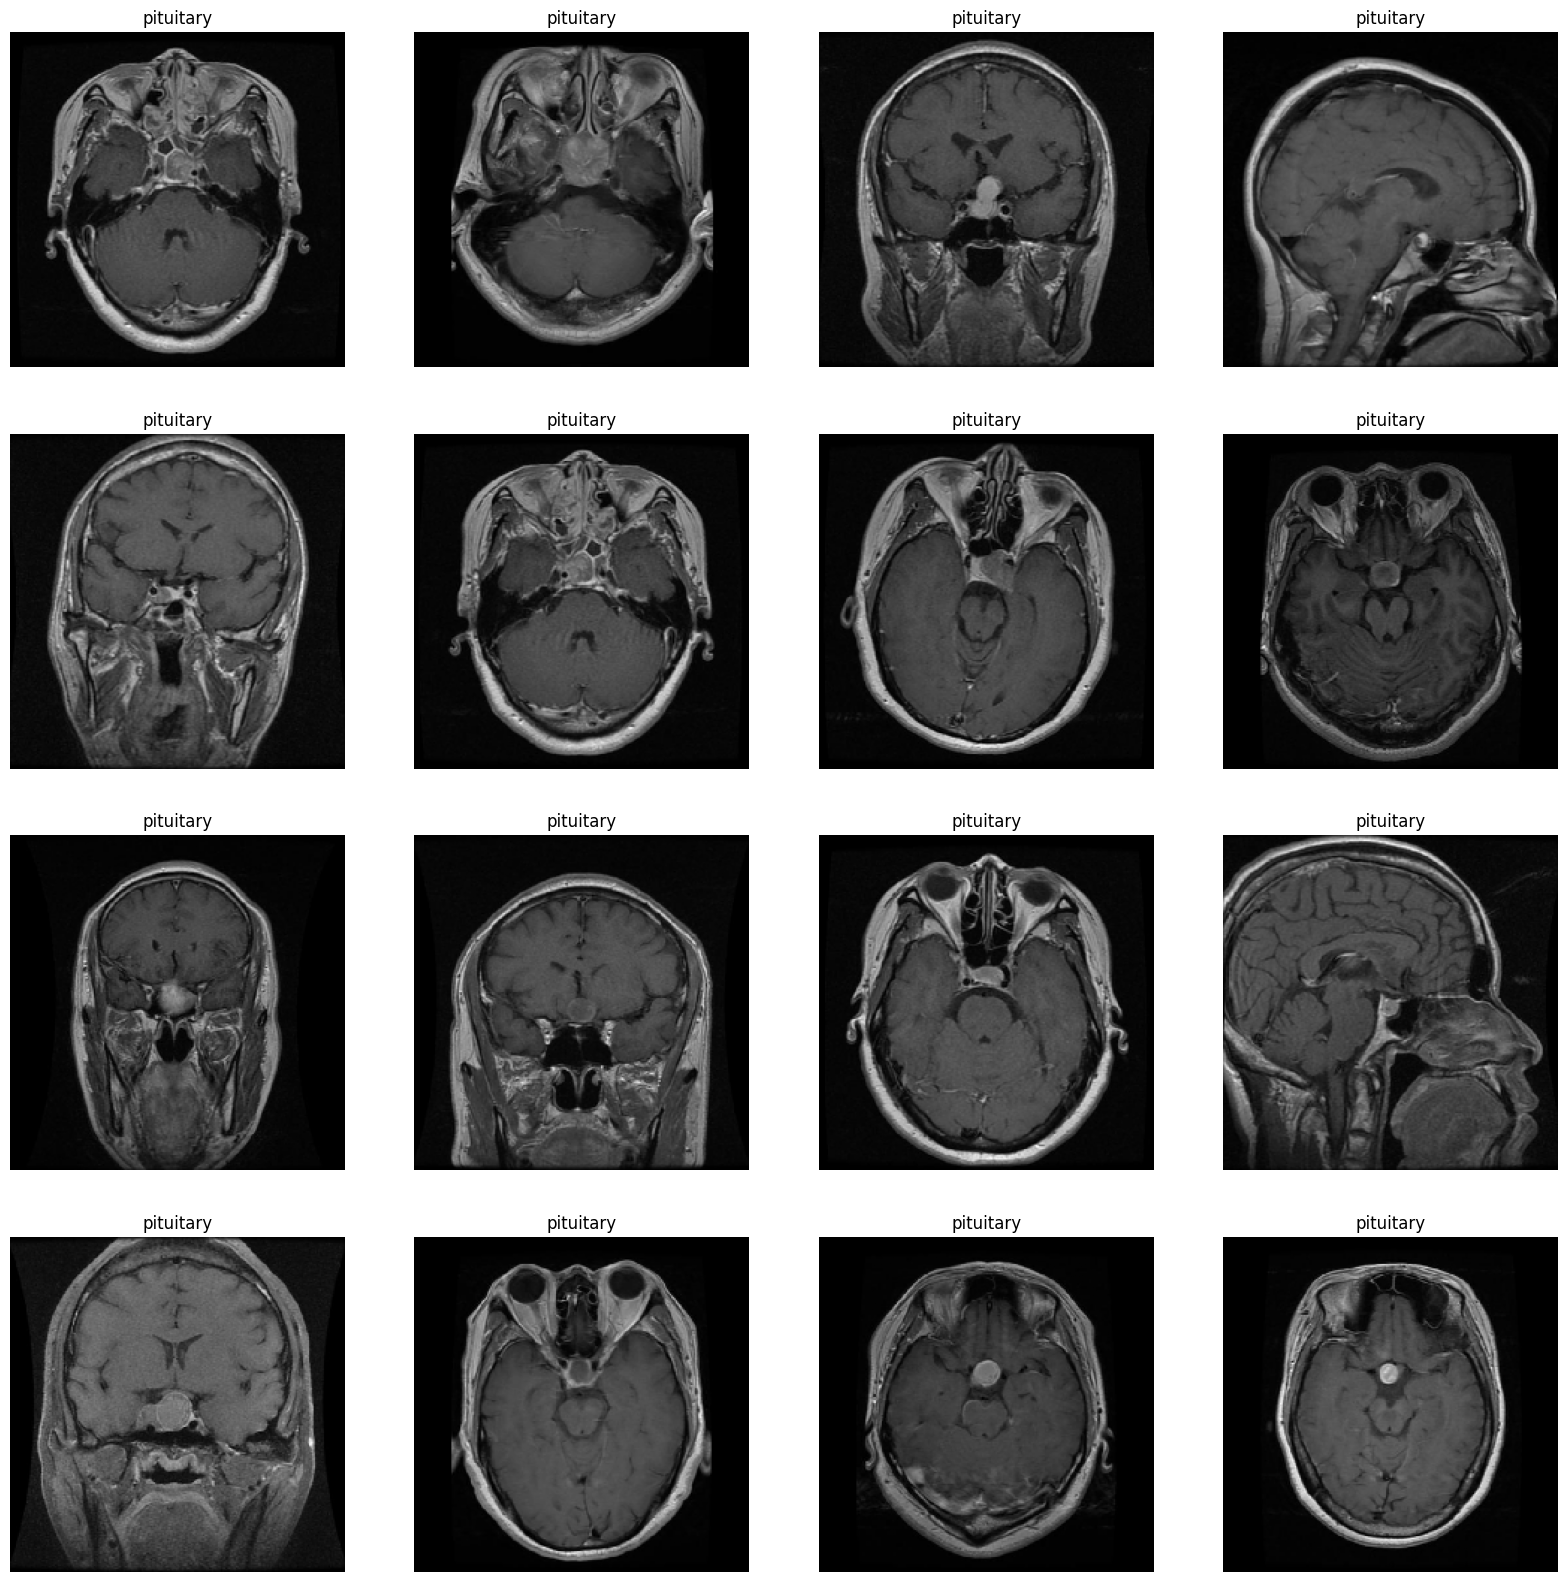

In [21]:
g_dict = test_gen.class_indices    
classes = list(g_dict.keys())      
images, labels = next(test_gen)     

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255      
    plt.imshow(image)
    index = np.argmax(labels[i])  
    class_name = classes[index]   
    plt.title(class_name, color= 'black', fontsize= 12)
    plt.axis('off')
plt.show()

# Build the CNN Model using Transfer Learning 

In [22]:

# Base model
base_model = EfficientNetB3(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

# Fine-tune some layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Custom head
x = base_model.output

# Additional convolutional layers for better feature extraction
x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = GlobalAveragePooling2D()(x)  # Global pooling
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

output = Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x)

# Build the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model with class weights
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        960 │ block1a_se_excit

 Total params: 14,424,499 (55.03 MB)

 Trainable params: 14,335,916 (54.69 MB)

 Non-trainable params: 88,583 (346.03 KB)

In [23]:
model.compile(loss= 'categorical_crossentropy',
                optimizer=Adamax(learning_rate= 0.0001),
                metrics=["accuracy"])

In [24]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [25]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(class_weight = "balanced", 
                                     classes= np.unique(train_gen.classes), 
                                     y= train_gen.classes) 
class_weights = dict(zip(np.unique(train_gen.classes), class_weights)) 
class_weights 

{0: 1.0806527909176915,
 1: 1.0665266106442577,
 2: 0.895180250783699,
 3: 0.9804721030042919}

In [26]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=50,
    class_weight=class_weights,
    shuffle=False,
    validation_steps= None,
    callbacks=[lr_scheduler, early_stopping]
)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734709562.799126      70 service.cc:145] XLA service 0x79322c006760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734709562.799192      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734709655.139847      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - accuracy: 0.4952 - loss: 10.2287 - val_accuracy: 0.6658 - val_loss: 9.5267 - learning_rate: 1.0000e-04
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 60s 416ms/step - accuracy: 0.7422 - loss: 9.3879 - val_accuracy: 0.7909 - val_loss: 9.2048 - learning_rate: 1.0000e-04
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 59s 414ms/step - accuracy: 0.7978 - loss: 9.1979 - val_accuracy: 0.8451 - val_loss: 8.9859 - learning_rate: 1.0000e-04
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 58s 404ms/step - accuracy: 0.8288 - loss: 9.0219 - val_accuracy: 0.8924 - val_loss: 8.7615 - learning_rate: 1.0000e-04
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 58s 406ms/step - accuracy: 0.8534 - loss: 8.8555 - val_accuracy: 0.9186 - val_loss: 8.5969 - learning_rate: 1.0000e-04
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 58s 405ms/step - accuracy: 0.8678 - loss: 8.7356 - val_accuracy: 0.9300 - val_loss: 8.4520 - learning_rate: 1.0000e-04
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 58s 403ms/step - a

In [27]:
train_history = pd.DataFrame(history.history)
train_history

accuracy      loss  val_accuracy  val_loss  learning_rate
0   0.596411  9.886364      0.665792  9.526739         0.0001
1   0.752681  9.370043      0.790901  9.204847         0.0001
2   0.799081  9.182456      0.845144  8.985947         0.0001
3   0.832786  8.987926      0.892388  8.761521         0.0001
4   0.858612  8.835920      0.918635  8.596935         0.0001
5   0.872620  8.691709      0.930009  8.452029         0.0001
6   0.884658  8.568018      0.944007  8.322103         0.0001
7   0.897352  8.410137      0.945757  8.193633         0.0001
8   0.903042  8.260168      0.951006  8.059377         0.0001
9   0.912891  8.103000      0.949256  7.930324         0.0001
10  0.922959  7.955565      0.958880  7.782925         0.0001
11  0.931714  7.795035      0.967629  7.611301         0.0001
12  0.932808  7.661941      0.977253  7.459333         0.0001
13  0.942876  7.482344      0.970254  7.318260         0.0001
14  0.937842  7.339248      0.973753  7.155904         0.0001
15  0.954476  7.154177      0.974628  6.998155         0.0001
16  0.953163  7.004326      0.978128  6.844308         0.0001
17  0.957102  6.839412      0.982502  6.679026         0.0001
18  0.959291  6.671998      0.980752  6.512743         0.0001
19  0.959729  6.505213      0.980752  6.362033         0.0001
20  0.961042  6.335483      0.987752  6.188373         0.0001
21  0.968046  6.165288      0.985127  6.033846         0.0001
22  0.966076  6.022067      0.982502  5.885030         0.0001
23  0.966732  5.856151      0.988626  5.730618         0.0001
24  0.969578  5.697242      0.983377  5.577848         0.0001
25  0.967170  5.559618      0.987752  5.424018         0.0001
26  0.973079  5.392560      0.986877  5.278609         0.0001
27  0.972204  5.255144      0.990376  5.134518         0.0001
28  0.981178  5.095710      0.986877  4.998711         0.0001
29  0.981178  4.955951      0.987752  4.856825         0.0001
30  0.980521  4.813676      0.986002  4.724267         0.0001
31  0.974174  4.696367      0.988626  4.590278         0.0001
32  0.979864  4.556708      0.988626  4.461145         0.0001
33  0.979208  4.434056      0.988626  4.340425         0.0001
34  0.978770  4.318749      0.987752  4.225351         0.0001
35  0.983147  4.190581      0.990376  4.112261         0.0001
36  0.988400  4.066164      0.991251  3.996921         0.0001
37  0.982491  3.969711      0.987752  3.887921         0.0001
38  0.983585  3.854717      0.988626  3.779346         0.0001
39  0.984898  3.749727      0.989501  3.674306         0.0001
40  0.985336  3.646631      0.988626  3.578688         0.0001
41  0.987087  3.539076      0.986002  3.482688         0.0001
42  0.985336  3.447164      0.993001  3.383971         0.0001
43  0.991026  3.336651      0.989501  3.293081         0.0001
44  0.989932  3.248393      0.992126  3.197078         0.0001
45  0.984023  3.174039      0.991251  3.107013         0.0001
46  0.987087  3.078289      0.991251  3.025375         0.0001
47  0.991245  2.980926      0.988626  2.948840         0.0001
48  0.990370  2.902079      0.987752  2.864609         0.0001
49  0.987087  2.832860      0.992126  2.775827         0.0001

<Axes: >

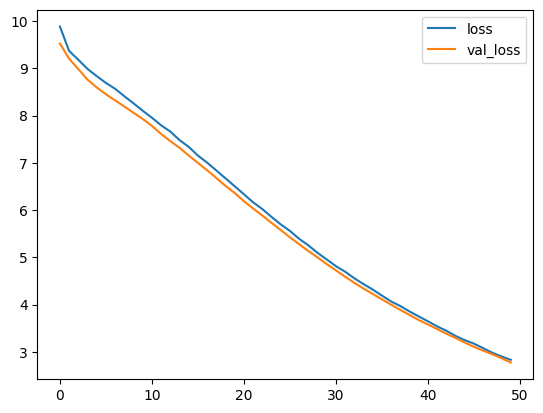

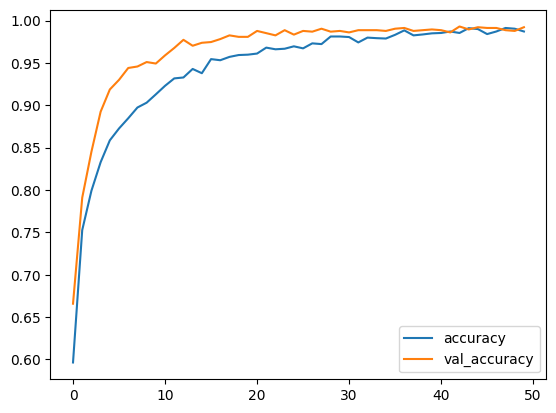

In [28]:
train_history[['loss' , 'val_loss']].plot.line()
train_history[['accuracy' , 'val_accuracy']].plot.line()

# Evaluation

In [29]:
ts_length = len(test_df1) 
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 366ms/step - accuracy: 1.0000 - loss: 2.7488
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - accuracy: 0.9869 - loss: 2.7842
 1/19 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.9688 - loss: 2.8665

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 245ms/step - accuracy: 0.9911 - loss: 2.7764
Train Loss:  2.7491981983184814
Train Accuracy:  1.0
--------------------
Valid Loss:  2.778355360031128
Valid Accuracy:  0.9884868264198303
--------------------
Test Loss:  2.759138584136963
Test Accuracy:  0.9967105388641357


# Prediction

In [30]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 23s 400ms/step


Text(95.72222222222221, 0.5, 'Actual Label\n')

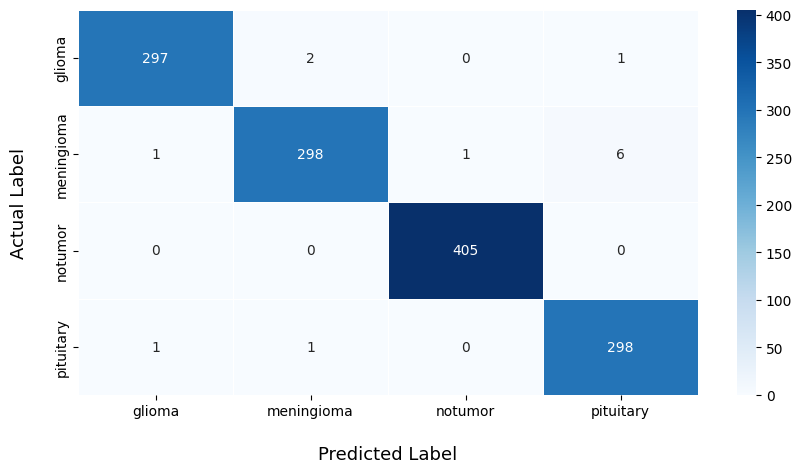

In [31]:
plt.figure(figsize=(10,5))
cm=confusion_matrix(test_gen.classes,y_pred)
labels = list(test_gen.class_indices.keys())
sns.heatmap(cm,annot=True,fmt="d",xticklabels=labels,yticklabels=labels,cmap="Blues", linewidths=.5)
plt.xlabel('\nPredicted Label',fontsize=13)
plt.ylabel('Actual Label\n',fontsize=13)

In [32]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

      glioma       0.99      0.99      0.99       300
  meningioma       0.99      0.97      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



# Saving the model

In [33]:
model.save('Brain3.h5')